### 🛠️ Setup & Initialization

In [3]:
# %%capture

import os
import torch
import sys
import torch
import warnings
warnings.filterwarnings("ignore")

from transformers import AutoProcessor, GenerationConfig
from modeling_bailingmm import BailingMMNativeForConditionalGeneration

# Load pre-trained model with optimized settings
model = BailingMMNativeForConditionalGeneration.from_pretrained(
    "inclusionAI/Ming-Lite-Omni",
    torch_dtype=torch.bfloat16,  # Use bfloat16 for memory efficiency
    low_cpu_mem_usage=True       # Minimize CPU memory during loading
).to("cuda")                     # Run on GPU

# Initialize processor for handling multimodal inputs
processor = AutoProcessor.from_pretrained("inclusionAI/Ming-Lite-Omni", trust_remote_code=True)

Loading checkpoint shards: 100%|██████████| 16/16 [09:35<00:00, 35.98s/it]
2025-07-07 18:18:59,038 - xformers - WARNING - WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.4.0+cu124)
    Python  3.10.13 (you have 3.10.15)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
2025-07-07 18:19:02,944 - diffusion.sana_loss - INFO - Preparation done. Starting training diffusion ...
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


### ⚙️ Inference Pipeline

In [35]:
def generate(messages):
    # 1. Format inputs using chat template
    text = processor.apply_chat_template(messages, add_generation_prompt=True)

    # 2. Extract vision/audio data
    image_inputs, video_inputs, audio_inputs = processor.process_vision_info(messages)

    # 3. Prepare tensor inputs
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        audios=audio_inputs,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)
    for k in inputs.keys():
        if k == "pixel_values" or k == "pixel_values_videos" or k == "audio_feats":
            inputs[k] = inputs[k].to(dtype=torch.bfloat16)

    # 4. Configure generation
    generation_config = GenerationConfig.from_dict({'no_repeat_ngram_size': 10})
    generated_ids = model.generate(
        **inputs,
        max_new_tokens=8192 * 2,
        use_cache=True,
        eos_token_id=processor.gen_terminator,
        generation_config=generation_config,
    )
    generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]

    # 5. Decode output
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]
    
    return output_text

### 💬 Text QA Example

In [36]:
# qa
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "text", "text": "请详细介绍鹦鹉的生活习性。"}
        ],
    },
]

from IPython.utils import io
with io.capture_output() as captured:
    output_text = generate(messages)

print("请详细介绍鹦鹉的生活习性。\n")
print("Answer:")
print(output_text)

请详细介绍鹦鹉的生活习性。

Answer:
鹦鹉是一类色彩鲜艳、聪明伶俐的鸟类，广泛分布于热带和亚热带地区。它们的生活习性丰富多样，以下是一些主要的生活习性：

### 1. **栖息环境**
鹦鹉主要栖息在热带和亚热带地区的森林、草原、灌木丛和农田等地。不同种类的鹦鹉对栖息环境的要求有所不同，有些喜欢茂密的森林，有些则适应开放的草原或农田。

### 2. **饮食习性**
鹦鹉是杂食性动物，主要以种子、果实、花朵、嫩芽和昆虫为食。它们的喙强壮有力，适合咬开坚硬的果壳和种子。一些鹦鹉还会食用泥土和沙子，以帮助消化。

### 3. **社交行为**
鹦鹉是高度社交的动物，通常生活在群体中。它们的社交结构可以是单对的，也可以是多对的，甚至是大群。鹦鹉之间的互动非常复杂，包括互相梳理羽毛、玩耍和发出各种声音。

### 4. **繁殖习性**
鹦鹉的繁殖季节因种类而异，但通常在雨季或气候温暖的时候进行。雌性鹦鹉通常在树洞或岩缝中筑巢，巢内铺有羽毛和植物材料。雌雄鹦鹉共同孵化蛋，孵化期一般为18-30天。孵化后，幼鸟会依赖父母喂养，直到它们能够独立觅食。

### 5. **发声和模仿**
鹦鹉以其出色的模仿能力著称，能够模仿人类的语言、声音和其他动物的叫声。这种能力不仅用于交流，还用于娱乐和吸引伴侣。

### 6. **智力与学习**
鹦鹉是高度智能的动物，具有较强的学习能力和记忆力。它们能够解决复杂的问题，使用工具，甚至进行简单的算术运算。鹦鹉的学习能力使它们能够适应多变的环境。

### 7. **迁徙习性**
虽然大多数鹦鹉是留鸟，但也有一些种类会进行短距离迁徙，以寻找食物或适宜的繁殖地。迁徙的时间和路线因种类而异。

### 8. **寿命**
鹦鹉的寿命较长，有些种类可以活到50-60年，甚至更长。人工饲养的鹦鹉如果得到良好的照顾，寿命可能会更长。

### 9. **保护现状**
由于栖息地的破坏、非法捕猎和宠物贸易，许多鹦鹉种类面临濒危。保护鹦鹉及其栖息地是保护生物多样性的重要任务。

### 10. **文化意义**
鹦鹉在许多文化中都有重要的地位，常常被视为智慧和美丽的象征。在古代，鹦鹉被作为礼物和装饰品，象征着财富和地位。

总的来说，鹦鹉是一种非常有趣和复杂的鸟类，其生活习性展示了它们在自然界中的适应能力和智慧。


### 🖼️ Image QA Example

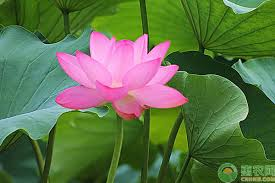

What kind of flower is this?

Answer: This is a lotus flower.


In [37]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "true"  # Use to suppress warnings

# image qa
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "image", "image": "figures/cases/flower.jpg"},
            {"type": "text", "text": "What kind of flower is this?"},
        ],
    },
]

from IPython.utils import io
with io.capture_output() as captured:  # used to suppress output inside the function
    output_text = generate(messages)

from IPython.display import display, Image
display(Image("figures/cases/flower.jpg"))
print("What kind of flower is this?\n")
print(f"Answer: {output_text}")

### 🤔 Chain-of-Thought Reasoning
**To enable thinking before response, adding the following system prompt before your question:**

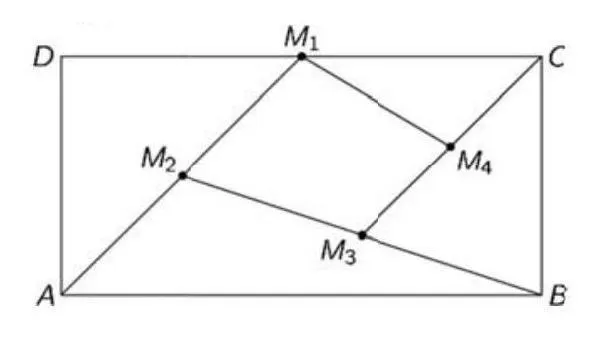

Input: Please answer the question and provide the correct option letter, e.g., A, B, C, D, at the end.
Question: Find $m\angle H$
Choices:
(A) 97
(B) 102
(C) 107
(D) 122

Answer:

<think>
Okay, so I'm trying to figure out the measure of angle H in this geometry problem. Let me start by understanding the setup. The image shows a rectangle ABCD with points M1, M2, M3, and M4 inside it. These points form a quadrilateral M1M2M3M4. The question is asking for the measure of angle H, which I assume is one of the angles in this quadrilateral.

First, I remember that in a rectangle, all angles are right angles, meaning each corner is 90 degrees. Also, the diagonals of a rectangle are equal in length and bisect each other. However, the points M1, M2, M3 are not necessarily the midpoints of the sides; they are just points inside the rectangle.

The image shows that M1 is the midpoint of side DC, M2 is the midpoint of side AD, M3 is the midpoint of side AB, and M4 is the midpoint of side BC. This 

In [38]:
import os
import json
os.environ["TOKENIZERS_PARALLELISM"] = "true"


cot_prompt = "SYSTEM: You are a helpful assistant. When the user asks a question, your response must include two parts: first, the reasoning process enclosed in <thinking>...</thinking> tags, then the final answer enclosed in <answer>...</answer> tags. The critical answer or key result should be placed within \\boxed{}.\n"
# And your input message should be like this:
question = "Please answer the question and provide the correct option letter, e.g., A, B, C, D, at the end.\nQuestion: Find $m\\angle H$\nChoices:\n(A) 97\n(B) 102\n(C) 107\n(D) 122"
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "image", "image": "figures/cases/reasoning.png"},
            {"type": "text", "text": cot_prompt + question},
        ],
    },
]

from IPython.utils import io
with io.capture_output() as captured: # used to suppress output inside the function
    output_text = generate(messages)

from IPython.display import display, Image
display(Image("figures/cases/reasoning.png"))
print(f"Input: {question}\n")
print("Answer:\n")
print(output_text)

### 🎥 Video QA Example

In [39]:
# video qa
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "video", "video": "figures/cases/yoga.mp4", "max_frames": 64, "sample": "uniform"},
            {"type": "text", "text": "What is the woman doing?"},
        ],
    },
]

from IPython.utils import io
with io.capture_output() as captured: # used to suppress output inside the function
    output_text = generate(messages)

import io
import base64
from IPython.display import HTML

video = io.open('figures/cases/yoga.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>
             <p>What is the woman doing in the video?</p>
             <p>Answer: {1}</p>
          '''.format(encoded.decode('ascii'), output_text))


2025-07-07 18:49:13,328 - bailingmm_utils - INFO - decord:  video_path='figures/cases/yoga.mp4', total_frames=300, video_fps=30.0, time=0.038s


### 💬 Multi-turn Conversation

In [40]:
# multi-turn chat
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "text", "text": "中国的首都是哪里？"},
        ],
    },
    {
        "role": "ASSISTANT",
        "content": [
            {"type": "text", "text": "北京"},
        ],
    },
    {
        "role": "HUMAN",
        "content": [
            {"type": "text", "text": "它有哪些著名景点？列出3个。"},
        ],
    },
]

from IPython.utils import io
with io.capture_output() as captured: # used to suppress output inside the function
    output_text = generate(messages)

print("Human: 中国的首都是哪里？")
print("Assistant: 北京")
print("Human: 它有哪些著名景点？列出3个。\n")

print("Answer:")
print(output_text)

Human: 中国的首都是哪里？
Assistant: 北京
Human: 它有哪些著名景点？列出3个。

Answer:
故宫、长城、天坛。


### 🔊 Audio Tasks

For detailed usage for ASR, SpeechQA, and TTS tasks, please refer to `test_audio_tasks.py`

In [41]:
import torch

# ASR
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "text", "text": "Please recognize the language of this speech and transcribe it. Format: oral."},
            {"type": "audio", "audio": 'data/wavs/BAC009S0915W0283.wav'},
        ],
    },
]

text = processor.apply_chat_template(messages, add_generation_prompt=True)
image_inputs, video_inputs, audio_inputs = processor.process_vision_info(messages)

# we use whisper encoder for ASR task, so need modify code above
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    audios=audio_inputs,
    return_tensors="pt",
    audio_kwargs={'use_whisper_encoder': True}
)
inputs = inputs.to(model.device)
for k in inputs.keys():
    if k == "pixel_values" or k == "pixel_values_videos" or k == "audio_feats":
        inputs[k] = inputs[k].to(dtype=torch.bfloat16)

generation_config = GenerationConfig.from_dict({'no_repeat_ngram_size': 10})
generated_ids = model.generate(
    **inputs,
    max_new_tokens=512,
    use_cache=True,
    eos_token_id=processor.gen_terminator,
    generation_config=generation_config,
    use_whisper_encoder=True
)

generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]

from IPython.display import display, Audio
display(Audio("data/wavs/BAC009S0915W0283.wav"))
print("Please recognize the language of this speech and transcribe it. Format: oral.\n")
print(f"Answer: {output_text}")

Please recognize the language of this speech and transcribe it. Format: oral.

Answer: Chinese	也正是看中了中国消费者的消费潜力


In [42]:
# speech2speech
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "audio", "audio": 'data/wavs/speechQA_sample.wav'},
        ],
    },
]

text = processor.apply_chat_template(messages, add_generation_prompt=True)
image_inputs, video_inputs, audio_inputs = processor.process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    audios=audio_inputs,
    return_tensors="pt",
    # audio_kwargs={'use_whisper_encoder': True}
)
inputs = inputs.to(model.device)
for k in inputs.keys():
    if k == "pixel_values" or k == "pixel_values_videos" or k == "audio_feats":
        inputs[k] = inputs[k].to(dtype=torch.bfloat16)

generation_config = GenerationConfig.from_dict({
    'output_hidden_states': True,
    'return_dict_in_generate': True,
    'no_repeat_ngram_size': 10}
)

outputs = model.generate(
    **inputs,
    max_new_tokens=512,
    use_cache=True,
    eos_token_id=processor.gen_terminator,
    generation_config=generation_config,
    use_whisper_encoder=False
)

generated_ids = outputs.sequences
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

# speechQA result
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]

# for TTS
from modeling_bailing_talker import AudioDetokenizer

from IPython.utils import io
with io.capture_output() as captured:
    model_name_or_path = model.config._name_or_path
    audio_detokenizer = AudioDetokenizer(
        f'{model_name_or_path}/talker/audio_detokenizer.yaml',
        flow_model_path=f'{model_name_or_path}/talker/flow.pt',
        hifigan_model_path=f'{model_name_or_path}/talker/hift.pt'
    )
    spk_input = torch.load('data/spks/luna.pt')
    thinker_reply_part = outputs.hidden_states[0][0] + outputs.hidden_states[0][-1]
    # Setting thinker_reply_part to None allows the talker to operate as a standalone TTS model, independent of the language model.
    audio_tokens = model.talker.omni_audio_generation(  
        output_text, 
        thinker_reply_part=thinker_reply_part, **spk_input)
    waveform = audio_detokenizer.token2wav(audio_tokens, save_path='data/wavs/out.wav', **spk_input)

from IPython.display import Audio, display
print("Input audio:")
display(Audio('data/wavs/speechQA_sample.wav'))

print("Output audio:")
display(Audio('data/wavs/out.wav'))

2025-07-07 18:49:22,735 - root - INFO - input frame rate=50


Input audio:


Output audio:


In [43]:
# zero-shot TTS
from modeling_bailing_talker import AudioDetokenizer
from audio_detokenizer.cli.frontend import TTSFrontEnd
from hyperpyyaml import load_hyperpyyaml

model_name_or_path = "inclusionAI/Ming-Lite-Omni"
audio_detokenizer = AudioDetokenizer(
    f'{model_name_or_path}/talker/audio_detokenizer.yaml',
    flow_model_path=f'{model_name_or_path}/talker/flow.pt',
    hifigan_model_path=f'{model_name_or_path}/talker/hift.pt'
)

with open(f'{model_name_or_path}/talker/audio_detokenizer.yaml', 'r') as f:
    configs = load_hyperpyyaml(f)
audio_frontend = TTSFrontEnd(
    configs["feat_extractor"],
    f'{model_name_or_path}/talker/campplus.onnx',
    f'{model_name_or_path}/talker/speech_tokenizer_v1.onnx',
)

tts_text = "这是一条测试语句。"
spk_input = audio_frontend.frontend_zero_shot(prompt_text="感谢你的认可。", prompt_wav_path="data/spks/prompt.wav")
audio_tokens = model.talker.omni_audio_generation(tts_text, **spk_input)
waveform = audio_detokenizer.token2wav(audio_tokens, save_path='data/waves/out2.wav', **spk_input)
print("Output audio:")
display(Audio('data/waves/out2.wav'))

2025-07-07 18:49:44,706 - root - INFO - input frame rate=50
2025-07-07 18:49:56,425 - root - INFO - input frame rate=50


LibsndfileError: Error opening 'data/waves/out2.wav': System error.

### 🎨 Image Generation & Editing

Ming-omni natively supports image generation and image editing. To use this function, you only need to add the corresponding parameters in the generate function.

In [ ]:
# Image generation mode currently limits the range of input pixels.
gen_input_pixels = 451584
processor.max_pixels = gen_input_pixels
processor.min_pixels = gen_input_pixels

def generate_image(messages, processor, model, **image_gen_param):
    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    image_inputs, video_inputs, audio_inputs = processor.process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        audios=audio_inputs,
        return_tensors="pt",
    ).to(model.device)

    for k in inputs.keys():
        if k == "pixel_values" or k == "pixel_values_videos" or k == "audio_feats":
            inputs[k] = inputs[k].to(dtype=torch.bfloat16)
    
    image = model.generate(
        **inputs,
        image_gen=True,
        **image_gen_param,
    )
    return image

Text-to-image generation

In [ ]:
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "text", "text": "Draw a girl with short hair."},
        ],
    }
]

from IPython.utils import io
with io.capture_output() as captured: # used to suppress output inside the function
    image = generate_image(
        messages=messages, processor=processor, model=model, 
        image_gen_cfg=6.0, image_gen_steps=20, image_gen_width=480, image_gen_height=544
    )
image.save("figures/cases/t2i.jpg")

print("Instruction: Draw a girl with short hair.")
from IPython.display import display, Image
display(Image("figures/cases/t2i.jpg"))

Image Editing

In [ ]:
messages = [
    {
        "role": "HUMAN",
        "content": [
            {"type": "image", "image": "figures/cases/cake.jpg"},
            {"type": "text", "text": "Add a candle on top of the cake"},
        ],
    }
]
from IPython.utils import io
with io.capture_output() as captured: # used to suppress output inside the function
    image = generate_image(
        messages=messages,
        processor=processor,
        model=model,
        image_gen_cfg=6.0,
        image_gen_steps=20,
        image_gen_width=512,
        image_gen_height=512,
    )
image.save("figures/cases/cake_edit.jpg")

from IPython.display import display, Image
display(Image("figures/cases/cake.jpg"))
print("Instruction: Add a candle on top of the cake.\n")

print("Output image:")
display(Image("figures/cases/cake_edit.jpg"))